This notebook considers the use of an array to transmit multiple values along a single wire in a wiring diagram. 

In [1]:
# Libraries
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Plots
using Plots.PlotMeasures
using DifferentialEquations

In [2]:
show_diagram(d::WiringDiagram) = to_graphviz(d,
  orientation=LeftToRight,
  labels=true, label_attr=:xlabel,
  node_attrs=Graphviz.Attributes(
    :fontname => "Helvetica",
  ),
  edge_attrs=Graphviz.Attributes(
    :fontname => "Helvetica",
  )
);

The wiring diagram is composed of two boxes with a single wire.

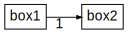

In [3]:
# Closed diagram
diagram = WiringDiagram( [], [] ); 

box1 = add_box!( diagram, Box(:box1, [], [:1]) );
box2 = add_box!( diagram, Box(:box2, [:1], []) );

# Connections
add_wires!(diagram, [
    (box1,1) => (box2,1) 
]);

show_diagram(diagram)

Each box has two states. By having the readout function of the first box output a 2D array, one might be able to transfer multiple values along a single wire.

In [4]:
# Constants
k1 = 1;     
k2 = 1;    
 
# State Functions 
equation1(u, x, p, t) = [ u[2], -k1*u[1] - k2*u[2] ]; 
equation2(u, x, p, t) = [ u[2], -k1*u[1] - k2*u[2] + x[1][1] ];  # Retrieve from the 1rst wire the 1rst value.

# Output functions: r(u) 
readout1(u) = [ [ u[1], u[2] ] ];  # A vector of arrays. Each vector element is a wire, each array element is a value.     
readout2(u) = [];           

In [5]:
# Constructing machines
                                # Inputs, States, Outputs
box1_machine = ContinuousMachine{Float32}( 0, 2, 1, equation1, readout1 );    
box2_machine = ContinuousMachine{Float32}( 1, 2, 0, equation2, readout2 );  

# Compose
net_machine = oapply(diagram, [box1_machine, box2_machine]);

Unfortunately this fails once it reaches the ODE solver. It appears to expect a number yet receives an array. The 2nd index appears to have no effect.  

In [56]:
u_init = [1, 0, 0, 0];
t_span = (0, 20); 

# This seems to be convertible into ODE form.
data = ODEProblem(net_machine, u_init, t_span)

# Attempt solving system
try 
    sol = solve( data, alg_hints=[:stiff] )
catch error
    print(error)
    print("\n\n Message w/o error block: \n")
    print( "MethodError: Cannot `convert` an object of type Array{Float64,1} to an object of type Float32" );
end

MethodError(convert, (Float32, [1.0, 0.0]), 0x0000000000006e5c)

 Message w/o error block: 
MethodError: Cannot `convert` an object of type Array{Float64,1} to an object of type Float32

If the readout function is modified to output an array of numbers the ODE solver will work. However this requires an additional wire between the boxes. 

In [ ]:
readout1(u) = [ u[1], u[2] ]; 

# Different type 

Changing the type of the continuous machine to an array may allow more data to be transferred per wire. Assume the readout function outputs an array of the form: [ [] ]

In the previous case with two boxes, the continuous machines seem to compile without issue. 

In [57]:
# Constructing machines
                                           # Inputs, States, Outputs
box1_machine = ContinuousMachine{ Array{Float32,1} }( 0, 2, 1, equation1, readout1 );  # first box outputs an array of floats

box2_machine = ContinuousMachine{ Float32 }( 1, 2, 0, equation2, readout2 ); # 2nd box outputs nothing, assume float?

Unfortunately assigning the machines to the diagram does not compile.

In [59]:
# Compose
net_machine = oapply(diagram, [box1_machine, box2_machine])

LoadError: [91mMethodError: no method matching oapply(::WiringDiagram{Any,Any,Any,Any}, ::Array{ContinuousMachine,1})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  oapply(::WiringDiagram, [91m::Array{Machine,1}[39m) where {T, Machine<:AbstractMachine{T}} at C:\Users\bobby\.julia\packages\AlgebraicDynamics\QtWNA\src\dwd_dynam.jl:215[39m
[91m[0m  oapply(::WiringDiagram, [91m::AbstractMachine[39m) at C:\Users\bobby\.julia\packages\AlgebraicDynamics\QtWNA\src\dwd_dynam.jl:262[39m
[91m[0m  oapply(::WiringDiagram, [91m::AbstractDict[39m) at C:\Users\bobby\.julia\packages\AlgebraicDynamics\QtWNA\src\dwd_dynam.jl:270[39m

## Modified diagram

The most basic case involves a single box that outputs an array. Lets see if this works.

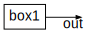

In [47]:
# Closed diagram
diagram = WiringDiagram( [], [:out] ); 

# Boxes
box1 = add_box!( diagram, Box(:box1, [], [:out]) );

add_wires!(diagram, [
    (box1,1) => (output_id(diagram), 1) 
]);

show_diagram(diagram)

The box has two states and outputs a single value which hopefully transmits an array. The datatype is an array.

In [60]:
# Machines:
                                # Inputs, States, Outputs
box1_machine = ContinuousMachine{ Array{Float32,1} }( 0, 2, 1, equation1, readout1 );      

Unfortunately this does not work either. It fails at the same point as before, when the boxes are assigned to the diagram.

In [61]:
# Compose
net_machine = oapply( diagram, [box1_machine] );

LoadError: [91mMethodError: no method matching zero(::Type{Array{Float32,1}})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  zero([91m::Type{Missing}[39m) at missing.jl:103[39m
[91m[0m  zero([91m::Type{Dates.DateTime}[39m) at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\Dates\src\types.jl:404[39m
[91m[0m  zero([91m::Type{Symbolics.TermCombination}[39m) at C:\Users\bobby\.julia\packages\Symbolics\JhAD8\src\linearity.jl:67[39m
[91m[0m  ...[39m